In [ ]:
import pandas as pd
import os
import zipfile
import json
import random
from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import transforms
from itertools import combinations, product
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open('output_folder/train/meta.json', 'r', encoding='utf-8') as f:
    meta = json.load(f)  # meta теперь обычный словарь (dict)

In [ ]:
id_to_images = {}  # ключ: id (строка '000000'), значение: список [(filename, label), ...]
root_dir = 'output_folder/train/images'


for key, value in meta.items():
    person_id = key.split('/')[0]   # "000000"
    filename  = key.split('/')[1]  # "0.jpg"
    if person_id not in id_to_images:
        id_to_images[person_id] = []
    id_to_images[person_id].append((filename, value))

all_ids = list(id_to_images.keys())

pairs = []

for idx in all_ids:
    imgs_pos = id_to_images[idx]

    positive_path = [os.path.join(root_dir, idx, i[0]) for i in imgs_pos if i[1] == 1]
    negative_path = [os.path.join(root_dir, idx, i[0]) for i in imgs_pos if i[1] == 0]

    positive_pairs = list(combinations(positive_path, 2))
    negative_pairs = list(product(negative_path, negative_path))

    positive_pairs_label = [(p[0], p[1], 1) for p in positive_pairs]
    negative_pairs_label = [(p[0], p[1], 0) for p in negative_pairs]

    pairs.extend(positive_pairs_label)
    pairs.extend(negative_pairs_label)

In [ ]:
class SeameseDataset(Dataset):
    def __init__(self,
                 pairs,
                 transform=None,):
        self.pairs = pairs
        self.transform = transform


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path1, img_path2, label = self.pairs[idx]

        # 3) Загрузка изображений
        image1 = Image.open(img_path1).convert('RGB')
        image2 = Image.open(img_path2).convert('RGB')

        # 4) Трансформации (если есть)
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        # 5) Возвращаем пару + метку
        return image1, image2, torch.tensor(label, dtype=torch.float32)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
siamese_dataset = SeameseDataset(pairs, transform=transform)

In [ ]:
vis_dataloader = DataLoader(
    siamese_dataset,
    shuffle=True,
    batch_size=512
)

In [ ]:
example_batch = next(iter(vis_dataloader))

In [ ]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


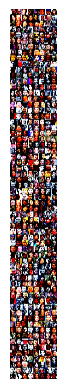

[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        self.feature_extractor = base_model.features

        # Заморозить фичи (по желанию)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(1280, 256),  # если AdaptiveAvgPool(1, 1)
            nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))


    def forward_one(self, x):
        x = self.feature_extractor(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



    def forward(self, img1, img2):
        out1 = self.forward_one(img1)
        out2 = self.forward_one(img2)
        return out1, out2

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +  # если разные, то расстояние должно быть большим
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  # если одинаковые, то маленьким
        )
        return loss

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

def compute_eer(y_true, y_score):
    fpr, tpr, threshold = roc_curve(y_true, y_score)

    # заменяем np.inf на max + eps
    eps = 1e-3
    threshold[0] = max(threshold[1:]) + eps

    fnr = 1 - tpr
    eer_index = np.nanargmin(np.absolute((fnr - fpr)))
    eer = fnr[eer_index]
    return eer

Epoch 1/1: 100%|██████████████████████████████████████████████████████| 647/647 [2:14:43<00:00, 12.49s/it, loss=0.0050]


Epoch [1/1] finished


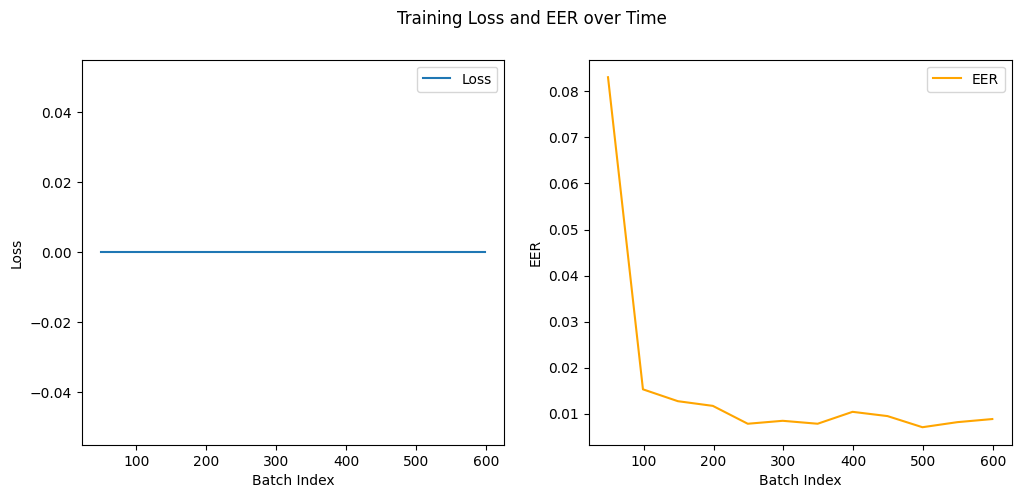

In [ ]:
num_epochs = 1
log_interval = 10        # в tqdm
metric_interval = 50     # как часто добавляем точку на график

# Хранилища для графика
loss_history = []
eer_history = []
timepoints = []   # это будет либо batch_idx, либо "глобальный счетчик"

# Модель и оптимизатор
siamese_net = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

global_batch_count = 0  # глобальный счетчик батчей

for epoch in range(num_epochs):
    running_loss = 0.0
    interval_labels = []
    interval_scores = []

    pbar = tqdm(enumerate(vis_dataloader), total=len(vis_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (img1, img2, label) in pbar:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        output1, output2 = siamese_net(img1, img2)
        distance = F.pairwise_distance(output1, output2)

        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Собираем данные для метрики
        interval_labels.extend(label.cpu().numpy())
        interval_scores.extend(distance.detach().cpu().numpy())

        if (batch_idx + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            pbar.set_postfix(loss=f"{avg_loss:.4f}")
            running_loss = 0.0

        # Каждые metric_interval батчей — сохраняем точку на график
        if (batch_idx + 1) % metric_interval == 0:
            avg_loss = np.mean(running_loss)  # усредненный лосс за последние батчи
            eer = compute_eer(np.array(interval_labels), np.array(interval_scores))

            loss_history.append(avg_loss)
            eer_history.append(eer)
            timepoints.append(global_batch_count)

            # Очистить буфер для следующего интервала
            interval_labels = []
            interval_scores = []

        global_batch_count += 1  # счетчик всех батчей (сквозной)

    print(f"Epoch [{epoch+1}/{num_epochs}] finished")

# 📊 Рисуем графики
plt.figure(figsize=(12, 5))

# Лосс график
plt.subplot(1, 2, 1)
plt.plot(timepoints, loss_history, label="Loss")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.legend()

# EER график
plt.subplot(1, 2, 2)
plt.plot(timepoints, eer_history, label="EER", color="orange")
plt.xlabel("Batch Index")
plt.ylabel("EER")
plt.legend()

plt.suptitle("Training Loss and EER over Time")
plt.show()

In [ ]:
# torch.save(siamese_net.state_dict(), 'siamese_model_1.pth')

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load("siamese_model_1.pth", map_location='cpu'))

# Указываем слои, которые хотим квантовать (например, Linear)
model_quantized = torch.quantization.quantize_dynamic(
    model,  # модель, которую квантуем
    {nn.Linear},  # типы слоев для квантизации
    dtype=torch.qint8
)

model_quantized.eval()

SiameseNetwork(
  (feature_extractor): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNor

In [ ]:
with zipfile.ZipFile('test_public.zip', 'r') as zip_ref:
    zip_ref.extractall('C:\\Users\\user')

In [ ]:
class TestPairDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.pair_ids = sorted(os.listdir(test_dir))
        self.transform = transform

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]
        pair_folder = os.path.join(self.test_dir, pair_id)
        img1_path = os.path.join(pair_folder, '0.jpg')
        img2_path = os.path.join(pair_folder, '1.jpg')

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return pair_id, img1, img2

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dir = 'C:\\Users\\user\\test_public\\images'

In [ ]:
dataset = TestPairDataset(test_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=False)

predictions = []

with torch.no_grad():
    for pair_ids, imgs1, imgs2 in tqdm(dataloader):
        imgs1, imgs2 = imgs1.to(device), imgs2.to(device)

        emb1, emb2 = model_quantized(imgs1, imgs2)
        similarity = F.cosine_similarity(emb1, emb2).cpu().numpy()

        for pair_id, sim in zip(pair_ids, similarity):
            predictions.append({'pair_id': pair_id, 'similarity': sim.item()})

# сохраняем submission
submission_df = pd.DataFrame(predictions)
submission_df = submission_df[['pair_id', 'similarity']]
submission_df.to_csv("submission.csv", index=False)

In [ ]:
class SiameseTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.pair_ids = sorted(os.listdir(test_dir))
        self.transform = transform

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]
        pair_folder = os.path.join(self.test_dir, pair_id)

        img1_path = os.path.join(pair_folder, '0.jpg')
        img2_path = os.path.join(pair_folder, '1.jpg')

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return pair_id, img1, img2

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dir = r'C:\Users\user\test_public\images'

dataset = SiameseTestDataset(test_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=False, pin_memory=True)

predictions = []

with torch.no_grad():
    for pair_ids, imgs1, imgs2 in tqdm(dataloader):
        imgs1, imgs2 = imgs1.to(device, non_blocking=True), imgs2.to(device, non_blocking=True)

        # Правильно извлекаем эмбеддинги отдельно
        emb1 = model_quantized.forward_one(imgs1)
        emb2 = model_quantized.forward_one(imgs2)

        similarity = F.cosine_similarity(emb1, emb2).cpu().numpy()

        predictions.extend([
            {'pair_id': pair_id, 'similarity': sim.item()}
            for pair_id, sim in zip(pair_ids, similarity)
        ])

submission_df = pd.DataFrame(predictions)
submission_df.to_csv("submission.csv", index=False)

 97%|████████████████████████████████████████████████████████████████████████████  | 307/315 [3:00:13<04:48, 36.06s/it]